In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/SEM2/ClusteringAssignment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
df = pd.read_csv("Country-data.csv")
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [ ]:
# Converting percentage exports, health and imports to dollar amounts

df["exports"] = df["exports"]*df["gdpp"]
df["health"] = df["health"]*df["gdpp"]
df["imports"] = df["imports"]*df["gdpp"]

In [ ]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,1.670000e+02,167.000000,1.670000e+02,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7.420619e+05,105673.320419,6.588352e+05,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,1.797389e+06,180140.890556,1.471081e+06,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920e+02,1282.120000,6.510920e+01,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,4.471400e+04,7853.550000,6.402150e+04,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1.777440e+05,32188.600000,2.045580e+05,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7.278000e+05,97694.000000,7.719600e+05,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,1.837500e+07,866360.000000,1.491000e+07,125000.000000,104.000000,82.800000,7.490000,105000.000000


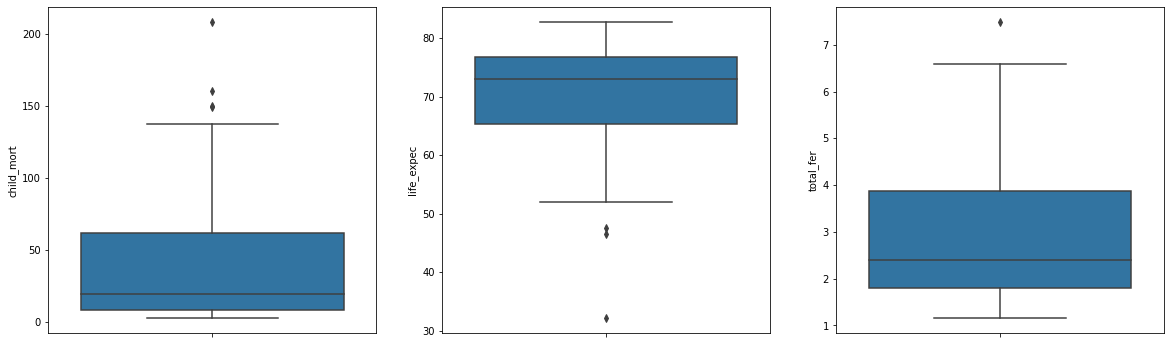

In [ ]:
# Visualizing variables and checking for outliers

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot( y = "child_mort", data = df)
plt.subplot(1,3,2)
sns.boxplot( y = "life_expec", data = df)
plt.subplot(1,3,3)
sns.boxplot( y = "total_fer", data = df)

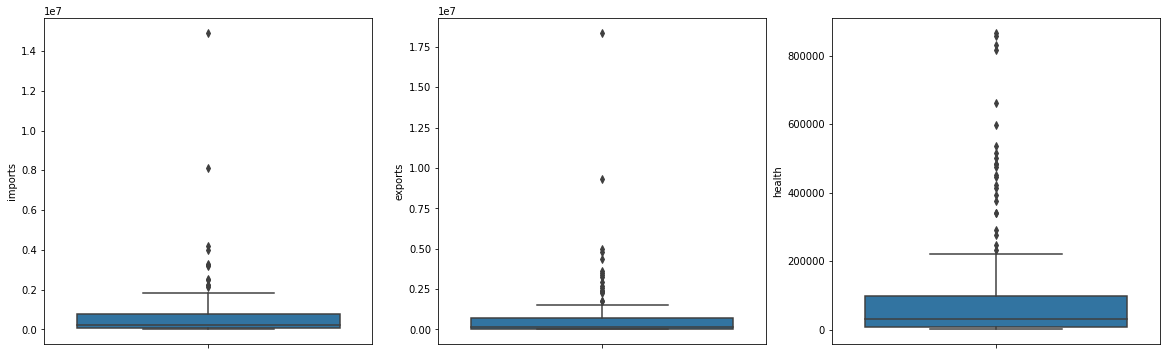

In [ ]:
# Visualising variables and checking for outliers

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot( y = "imports", data = df)
plt.subplot(1,3,2)
sns.boxplot( y = "exports", data = df)
plt.subplot(1,3,3)
sns.boxplot( y = "health", data = df)

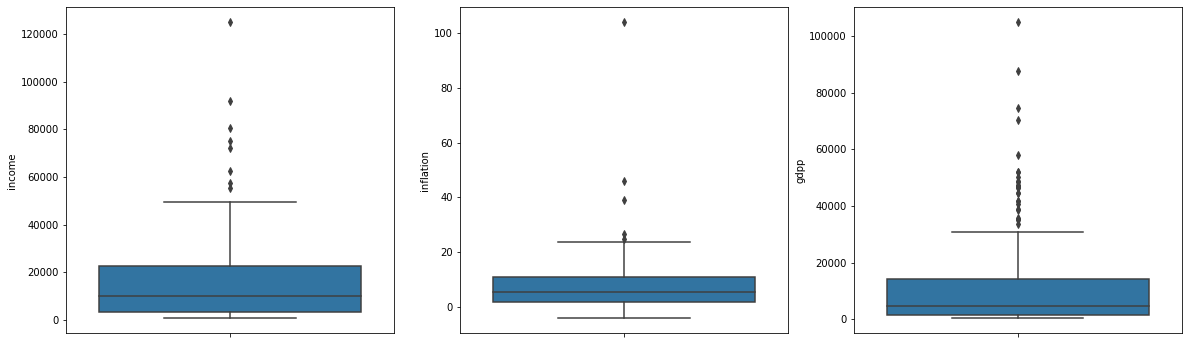

In [ ]:
# Visualizing variables and checking for outliers

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot( y = "income", data = df)
plt.subplot(1,3,2)
sns.boxplot( y = "inflation", data = df)
plt.subplot(1,3,3)
sns.boxplot( y = "gdpp", data = df)

In [ ]:
# Capping outliers above the upper whisker in "exports", "health", "imports", "income", "inflation", "total_fer" and "gdpp"
# child_mort does not have any outliers below the lower whisker

clip_cols = ["exports","health","imports","income","inflation","total_fer","gdpp"]
df[clip_cols] = df[clip_cols].clip(upper = df[clip_cols].quantile(0.99),axis =1 )

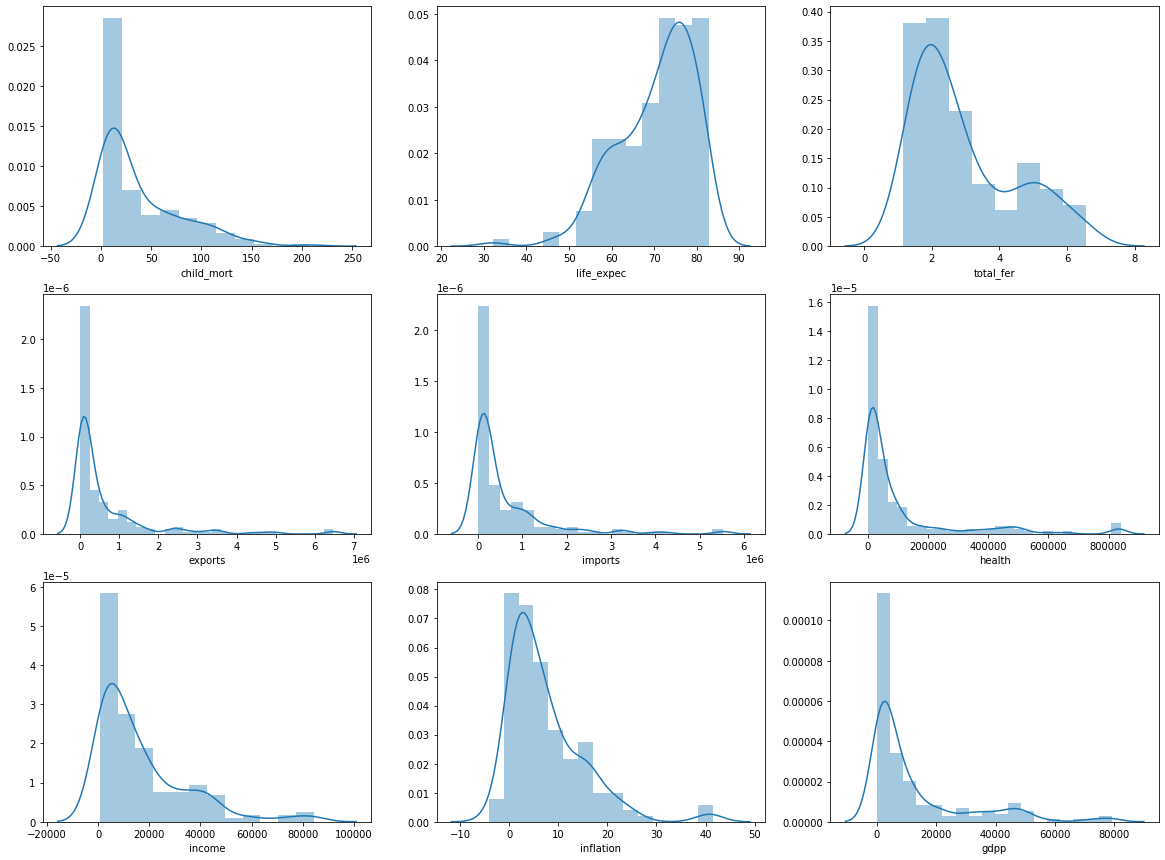

In [ ]:
# Visualising histograms for all the variables

plt.figure(figsize=(20,15))
feature = ["child_mort",  "life_expec", "total_fer", "exports", "imports", "health", "income", "inflation", "gdpp"]
for i in enumerate(feature):
  plt.subplot(3,3, i[0]+1)
  sns.distplot(df[i[1]])

### Scaling using StandardScaler()

In [ ]:
# rescaling

df1 = df[['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']]

# instantiating
scaler = StandardScaler()

# fit_transform
df_scaled = scaler.fit_transform(df1)
df_scaled.shape

(167, 9)

In [ ]:
# Converting df_scaled to a Data Frame

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['child_mort', 'exports', 'health', 'imports', 'income','inflation', 'life_expec', 'total_fer', 'gdpp']
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.265002,-1.619092,1.926396,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.372075,0.647866,-0.865054,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,1.122161,0.670423,-0.034983,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.932987,-1.179234,2.153997,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.764618,0.704258,-0.543736,-0.032042


### Hopkins Statistic for measuring the cluster tendency of the data set.

In [ ]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H
hopkins(df_scaled)

0.8959462863463079

As the Hopkins Score is 0.89 (greater than 0.7), the data can be used to form clusters

### Finding the optimum number of clusters

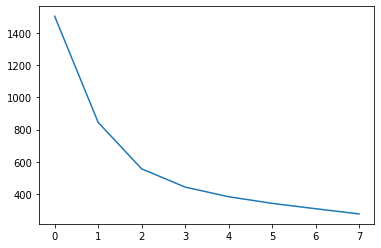

In [ ]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plotting the SSDs for each n_clusters
plt.plot(ssd)

As per the elbow curve above, forming 3 clusters (point 2 on the x-axis) would be ideal

### Silhouette Analysis

In [ ]:
# silhouette analysis
range_n_clusters = [3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=3, the silhouette score is 0.4035259981391569
For n_clusters=4, the silhouette score is 0.3919682996098615
For n_clusters=5, the silhouette score is 0.38416316490898117
For n_clusters=6, the silhouette score is 0.2970127675259783
For n_clusters=7, the silhouette score is 0.3045897551027583
For n_clusters=8, the silhouette score is 0.3196828950637381


The number of clusters with the highest silhouette score here is 3.

### Modelling using K-Means

In [ ]:
# model with k=3

kmeans = KMeans(n_clusters=3, max_iter=50, random_state=50)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [ ]:
centers = kmeans.cluster_centers_
centers

array([[-0.44076502, -0.26897266, -0.29421423, -0.24322897, -0.17054062,
        -0.03475297,  0.32004093, -0.46846451, -0.28474303],
       [-0.82787747,  1.65776403,  1.78390767,  1.64390314,  1.72745191,
        -0.57971219,  1.11922578, -0.79534307,  1.91687296],
       [ 1.32661038, -0.49724204, -0.52612588, -0.53713716, -0.72390519,
         0.41540461, -1.27627565,  1.35889073, -0.62421756]])

In [ ]:
# assigning the labels to a new column in df

df['cluster_id'] = kmeans.labels_
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,5530.0,4191.74,24829.7,1610,9.44,56.2,5.82,553,2
1,Albania,16.6,114520.0,26789.50,198774.0,9930,4.49,76.3,1.65,4090,0
2,Algeria,27.3,171264.0,18598.20,140044.0,12900,16.10,76.5,2.89,4460,0
3,Angola,119.0,219919.0,10060.50,151437.0,5900,22.40,60.1,6.16,3530,2
4,Antigua and Barbuda,10.3,555100.0,73566.00,718580.0,19100,1.44,76.8,2.13,12200,0


In [ ]:
# Converting child mortality rate per thousand to child mortality rate per million for better visualisation

df["child_mort_per_million"] = df["child_mort"]*1000

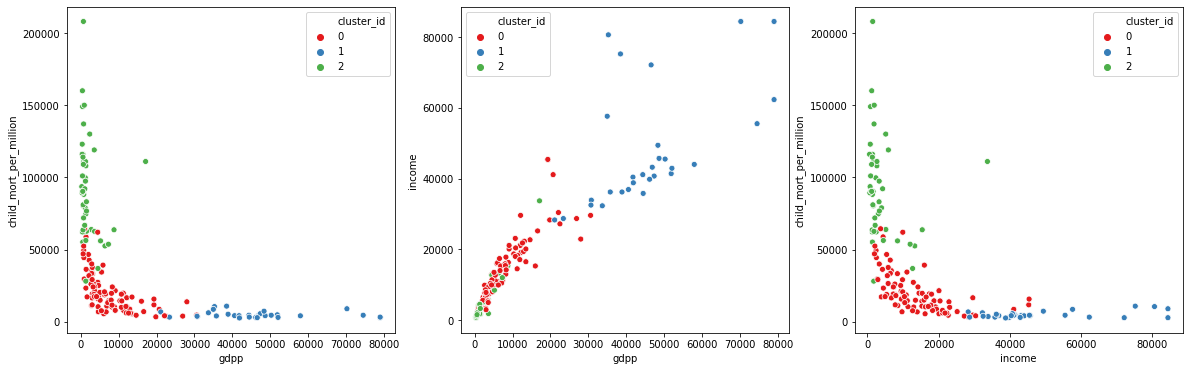

In [ ]:
# Visualising clusters using scatter plots

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.scatterplot(x = "gdpp", y = 'child_mort_per_million' , data = df, hue = "cluster_id", palette = "Set1")
plt.subplot(1,3,2)
sns.scatterplot(x = "gdpp", y = "income" , data = df, hue = "cluster_id", palette = "Set1")
plt.subplot(1,3,3)
sns.scatterplot(x = "income", y = 'child_mort_per_million' , data = df, hue = "cluster_id", palette = "Set1")

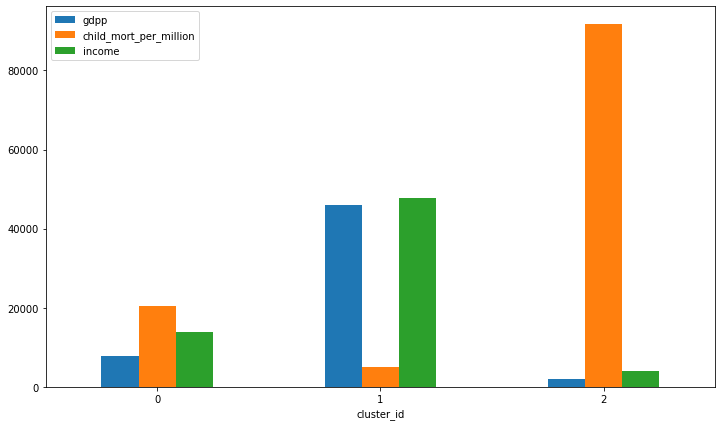

In [ ]:
# Plotting average of "gdpp", 'child_mort_per_million', "income" for each cluster

df[["gdpp", 'child_mort_per_million', "income"]].groupby(df["cluster_id"]).mean().plot(kind= "bar", figsize = (12,7),rot=0)

From the above plots we can see that:
* **Cluster-0** has intermediate average gdpp, intermediate average child mortality, intermediate average income
* **Cluster-1** has high average gdpp, low average child mortality, high average income
* **Cluster-2** has low average gdpp, high average child mortality and low average income

Hence, we can say that the countries in **Cluster-2** are in direst need of aid

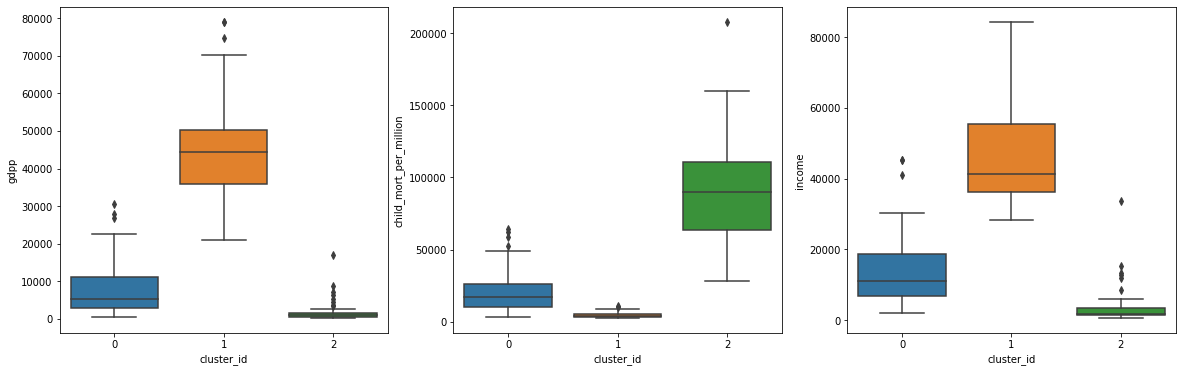

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot(x='cluster_id', y='gdpp', data=df)
plt.subplot(1,3,2)
sns.boxplot(x='cluster_id', y='child_mort_per_million', data=df)
plt.subplot(1,3,3)
sns.boxplot(x='cluster_id', y='income', data=df)

From the scatter plot, bar graph and boxplots above, we can say that the type of countries we should be looking at are in **Cluster-2**

In [ ]:
# Top 5 countries in cluster-2 with low gdpp, high child mortality per million and low income

df_final = df[df["cluster_id"] == 2][["country","gdpp","child_mort_per_million","income"]].sort_values(by = ["gdpp","child_mort_per_million","income"], ascending = [True,False,True])
df_final.head()

,country,gdpp,child_mort_per_million,income
26,Burundi,231,93600.0,764
88,Liberia,327,89300.0,700
37,"Congo, Dem. Rep.",334,116000.0,609
112,Niger,348,123000.0,814
132,Sierra Leone,399,160000.0,1220


With the K-means clustering approach following are the 5 countries that are in the direst need of aid:

1. Burundi
2. Liberia
3. Congo, Dem. Rep. (Democratic Republic of the Congo)
4. Niger
5. Sierra Leone





## Hierarchical Clustering

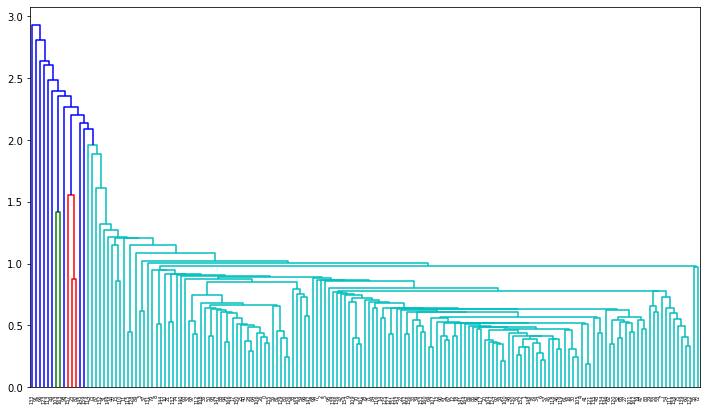

In [ ]:
# single linkage

mergings = linkage(df_scaled, method="single", metric='euclidean')
plt.figure(figsize=(12,7))
dendrogram(mergings)
plt.show()

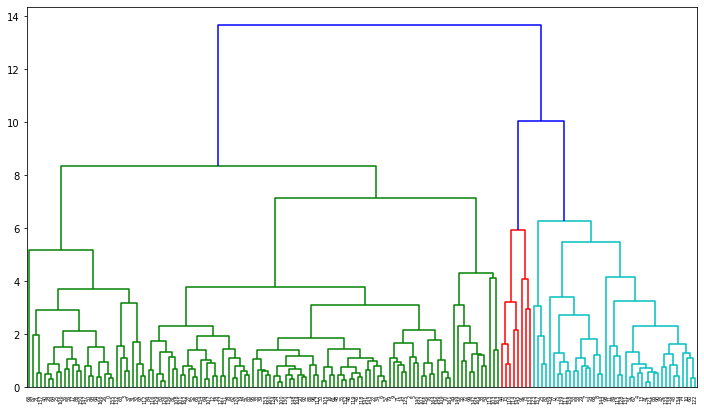

In [ ]:
# complete linkage

mergings = linkage(df_scaled, method="complete", metric='euclidean')
plt.figure(figsize=(12,7))
dendrogram(mergings)
plt.show()

Complete linkage shows a clearer segregation of clusters, hence using it for further analysis.

In [ ]:
# 3 clusters

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Assigning cluster labels in a new column in df

df['cluster_labels'] = cluster_labels
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,child_mort_per_million,cluster_labels
0,Afghanistan,90.2,5530.0,4191.74,24829.7,1610,9.44,56.2,5.82,553,2,90200.0,0
1,Albania,16.6,114520.0,26789.50,198774.0,9930,4.49,76.3,1.65,4090,0,16600.0,0
2,Algeria,27.3,171264.0,18598.20,140044.0,12900,16.10,76.5,2.89,4460,0,27300.0,0
3,Angola,119.0,219919.0,10060.50,151437.0,5900,22.40,60.1,6.16,3530,2,119000.0,0
4,Antigua and Barbuda,10.3,555100.0,73566.00,718580.0,19100,1.44,76.8,2.13,12200,0,10300.0,1


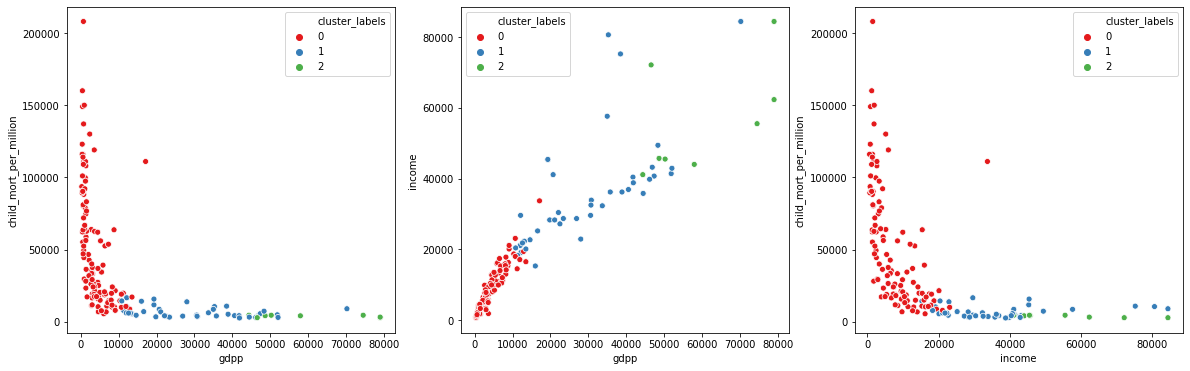

In [ ]:
# Visualising clusters using scatter plots

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.scatterplot(x = "gdpp", y = 'child_mort_per_million' , data = df, hue = "cluster_labels", palette = "Set1")
plt.subplot(1,3,2)
sns.scatterplot(x = "gdpp", y = "income" , data = df, hue = "cluster_labels", palette = "Set1")
plt.subplot(1,3,3)
sns.scatterplot(x = "income", y = 'child_mort_per_million' , data = df, hue = "cluster_labels", palette = "Set1")

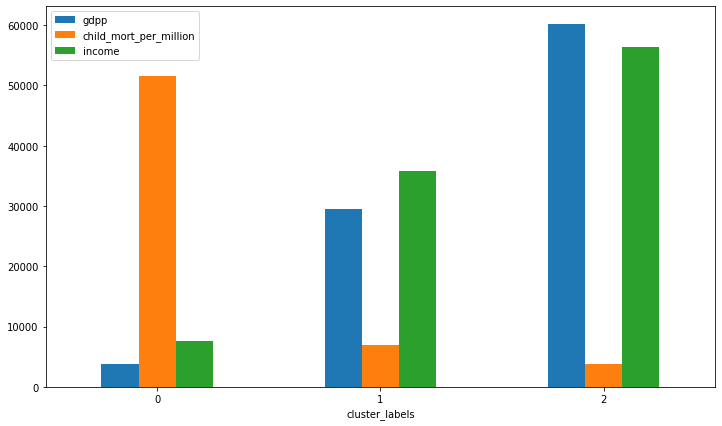

In [ ]:
# Plotting average of "gdpp", 'child_mort_per_million', "income" for each cluster

df[["gdpp", 'child_mort_per_million', "income"]].groupby(df["cluster_labels"]).mean().plot(kind= "bar",figsize = (12,7),rot=0)

From the above plots we can see that:
* **Cluster-0** has low average gdpp, high average child mortality and low average income
* **Cluster-1** has intermediate average gdpp, low average child mortality, intermediate average income
* **Cluster-2** has high average gdpp, low average child mortality, high average income

Hence, we can say that the countries in **Cluster-0** are in direst need of aid

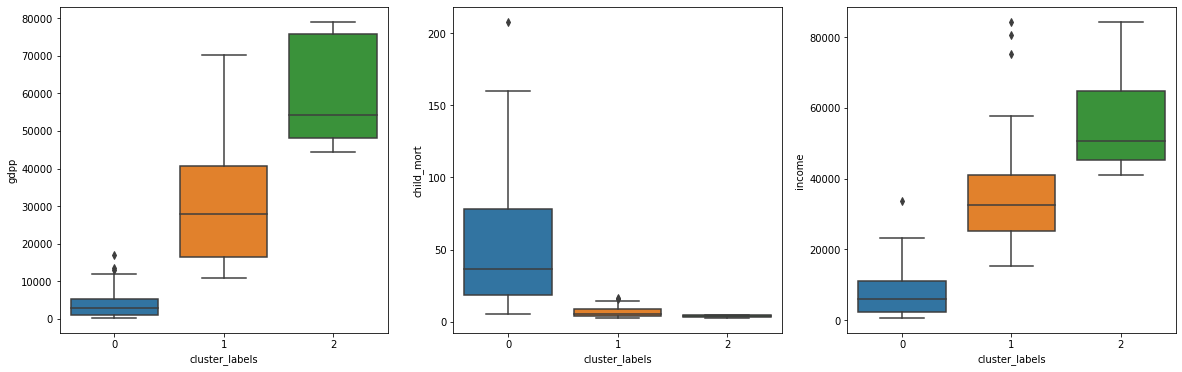

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.boxplot(x='cluster_labels', y='gdpp', data=df)
plt.subplot(1,3,2)
sns.boxplot(x='cluster_labels', y='child_mort', data=df)
plt.subplot(1,3,3)
sns.boxplot(x='cluster_labels', y='income', data=df)

From the scatter plot, bar graph and boxplots above, we can say that the type of countries we should be looking at are in **Cluster-0**

In [ ]:
# Top 5 countries in cluster-0 with low gdpp, high child mortality per million and low income

df_final = df[df["cluster_labels"] == 0][["country","gdpp","child_mort_per_million","income"]].sort_values(by = ["gdpp","child_mort_per_million","income"], ascending = [True,False,True])
df_final.head()

,country,gdpp,child_mort_per_million,income
26,Burundi,231,93600.0,764
88,Liberia,327,89300.0,700
37,"Congo, Dem. Rep.",334,116000.0,609
112,Niger,348,123000.0,814
132,Sierra Leone,399,160000.0,1220


With the Hierarchical clustering approach following are the 5 countries that are in the direst need of aid:
1. Burundi
2. Liberia
3. Congo, Dem. Rep. (Democratic Republic of the Congo)
4. Niger
5. Sierra Leone


K-means clustering and Hierarchical clustering show the exact same 5 African countries that are in the direst need of aid. 

# Fin!